## Package Import 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time

from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from functools import partial
from sklearn.model_selection import train_test_split

In [2]:
def plot_history(model):
    f,ax=plt.subplots(2,1,figsize=(10,10)) 

    # training loss and validation loss
    ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
    ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

    # training accuracy and validation accuracy
    ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
    ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

    plt.legend()

## Load Dataset

### Load dataset from Keras

In [3]:
# import the dataset from keras
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [4]:
# split the train set into train set and validation set
x_train, x_validation, y_train, y_validation = train_test_split(x_train,y_train,test_size=.2)

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_ds = tf.data.Dataset.from_tensor_slices((x_validation, y_validation))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

2021-12-18 23:01:01.445640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 23:01:01.453672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 23:01:01.454345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-18 23:01:01.456754: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

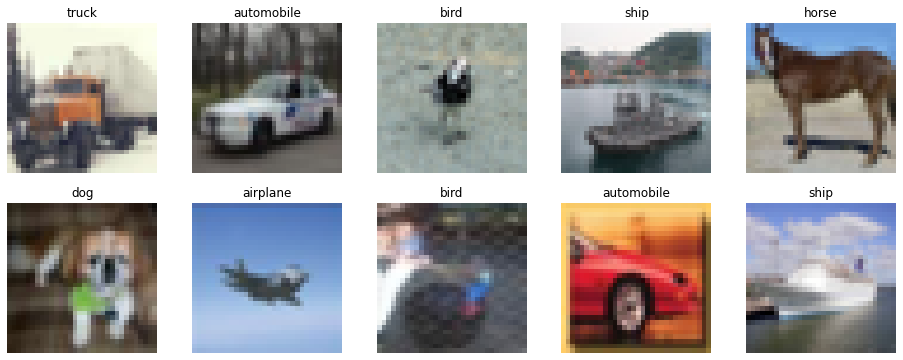

In [6]:
label_str = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(16, 16))
for i,(image,label) in enumerate(train_ds.take(10)):
    ax=plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(label_str[label.numpy()[0]])
    plt.axis('off')

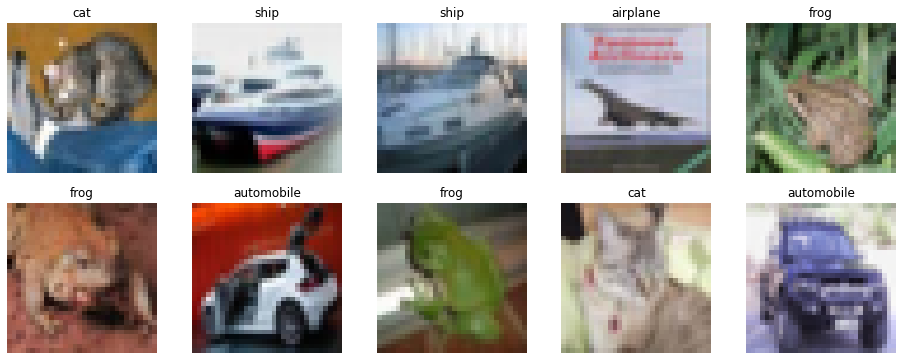

In [7]:
plt.figure(figsize=(16, 16))
for i,(image,label) in enumerate(test_ds.take(10)):
    ax=plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.title(label_str[label.numpy()[0]])
    plt.axis('off')

## AlexNet

In [8]:
def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 227x227
    image = tf.image.resize(image, (64, 64))
    return image, label

In [9]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()
print("Train size:", train_ds_size)
print("Test size:", test_ds_size)
print("Validation size:", validation_ds_size)

Train size: 40000
Test size: 10000
Validation size: 10000


In [10]:
train_ds = (train_ds
            # pre-process the image
            .map(process_images)
            # shuffle the dataset
            .shuffle(buffer_size=train_ds_size)
            # batch dataset
            .batch(batch_size=32, drop_remainder=True))

# do the same for the test set and the validation set
test_ds = (test_ds
           .map(process_images)
           .shuffle(buffer_size=train_ds_size)
           .batch(batch_size=32, drop_remainder=True))

validation_ds = (validation_ds
                 .map(process_images)
                 .shuffle(buffer_size=train_ds_size)
                 .batch(batch_size=32, drop_remainder=True))

In [11]:
# define the model
alex = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)), # I wanted to use 227x227 but there's no enough memory on kaggle
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(2048,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2048,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')  
])

In [12]:
alex.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])
alex.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 128)       46592     
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 256)         819456    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 256)         1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 256)         5

In [13]:
alex.fit(train_ds,
         epochs=50,
         validation_data=validation_ds,
         validation_freq=1)

Epoch 1/50


2021-12-18 23:01:05.447466: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-18 23:01:09.171502: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1250/1250 [==============================] - 15s 7ms/step - loss: 2.0683 - accuracy: 0.2565 - val_loss: 1.6010 - val_accuracy: 0.4189
Epoch 2/50
1250/1250 [==============================] - 13s 7ms/step - loss: 1.6946 - accuracy: 0.3830 - val_loss: 1.4164 - val_accuracy: 0.4906
Epoch 3/50
1250/1250 [==============================] - 12s 7ms/step - loss: 1.5155 - accuracy: 0.4532 - val_loss: 1.2954 - val_accuracy: 0.5332
Epoch 4/50
1250/1250 [==============================] - 12s 7ms/step - loss: 1.3855 - accuracy: 0.5031 - val_loss: 1.2198 - val_accuracy: 0.5599
Epoch 5/50
1250/1250 [==============================] - 12s 7ms/step - loss: 1.2863 - accuracy: 0.5374 - val_loss: 1.1491 - val_accuracy: 0.5892
Epoch 6/50
1250/1250 [==============================] - 13s 7ms/step - loss: 1.1978 - accuracy: 0.5741 - val_loss: 1.1205 - val_accuracy: 0.6029
Epoch 7/50
1250/1250 [==============================] - 12s 7ms/step - loss: 1.1169 - accuracy: 0.6058 - val_loss: 1.0690 - val_accuracy: 0.6

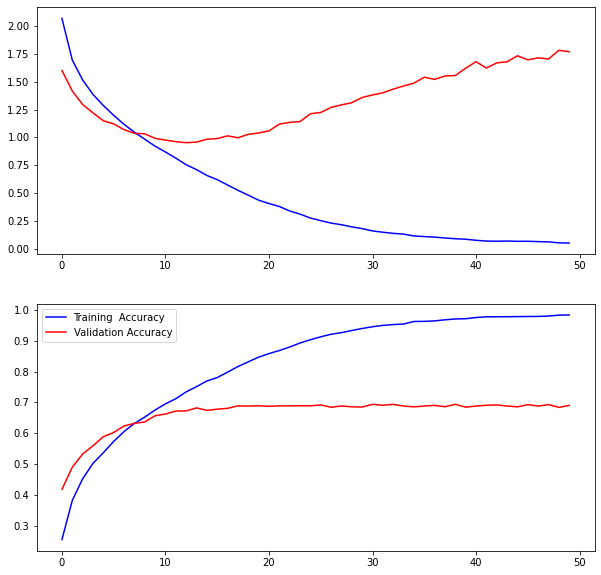

In [14]:
plot_history(alex)

In [15]:
# Normalization
x_train = x_train/255
x_validation = x_validation/255
x_test = x_test/255

# encode the labels
y_train=np_utils.to_categorical(y_train)
y_validation=np_utils.to_categorical(y_validation)
y_test=np_utils.to_categorical(y_test)
print((x_train.shape,y_train.shape))
print((x_validation.shape,y_validation.shape))
print((x_test.shape,y_test.shape))

((40000, 32, 32, 3), (40000, 10))
((10000, 32, 32, 3), (10000, 10))
((10000, 32, 32, 3), (10000, 10))


In [16]:
# data augumentation
train_generator = ImageDataGenerator(rotation_range=2, 
                                     horizontal_flip=True,
                                     zoom_range=.1 )

val_generator = ImageDataGenerator(rotation_range=2, 
                                   horizontal_flip=True,
                                   zoom_range=.1)

test_generator = ImageDataGenerator(rotation_range=2, 
                                    horizontal_flip= True,
                                    zoom_range=.1)
train_generator.fit(x_train)
val_generator.fit(x_validation)
test_generator.fit(x_test)

## VGG-19

In [17]:
# change the learning rate if the validation error does not reduce after a set number of epochs
lr_reducer = ReduceLROnPlateau(monitor='val_acc', # metric to be used
                               factor=.01, # reduce rate
                               patience=3, # number of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                               min_lr=1e-5) # the minimum learning rate 

early_stopper = EarlyStopping(min_delta=0.001, patience=5)

In [18]:
# import the pre-trained model
vgg = keras.applications.vgg19.VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])

In [19]:
# finish building the model
vgg19 = keras.models.Sequential()
vgg19.add(vgg)
vgg19.add(keras.layers.Flatten())
vgg19.add(keras.layers.Dense(1024,activation=('relu'),input_dim=512))
vgg19.add(keras.layers.Dense(512,activation=('relu'))) 
vgg19.add(keras.layers.Dense(256,activation=('relu'))) 
vgg19.add(keras.layers.Dense(128,activation=('relu')))
vgg19.add(keras.layers.Dense(10,activation=('softmax'))) #This is the classification layer
vgg19.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

In [20]:
# use momentum optimizer
sgd = tf.optimizers.SGD(learning_rate=.001,momentum=.9,nesterov=False)

In [21]:
batch_size = 100
epochs = 50
vgg19.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])
vgg19.fit(train_generator.flow(x_train,y_train,batch_size=batch_size),
          epochs=epochs,
          validation_data=val_generator.flow(x_validation,y_validation,batch_size=batch_size),
          validation_freq=1,
          callbacks=[lr_reducer, early_stopper])

Epoch 1/50
400/400 [==============================] - 29s 69ms/step - loss: 1.2931 - accuracy: 0.5454 - val_loss: 0.8805 - val_accuracy: 0.6919
Epoch 2/50
400/400 [==============================] - 28s 69ms/step - loss: 0.7972 - accuracy: 0.7230 - val_loss: 0.7290 - val_accuracy: 0.7524
Epoch 3/50
400/400 [==============================] - 27s 68ms/step - loss: 0.6645 - accuracy: 0.7699 - val_loss: 0.6202 - val_accuracy: 0.7895
Epoch 4/50
400/400 [==============================] - 27s 68ms/step - loss: 0.5833 - accuracy: 0.7983 - val_loss: 0.5941 - val_accuracy: 0.7950
Epoch 5/50
400/400 [==============================] - 27s 69ms/step - loss: 0.5290 - accuracy: 0.8162 - val_loss: 0.5479 - val_accuracy: 0.8107
Epoch 6/50
400/400 [==============================] - 27s 68ms/step - loss: 0.4771 - accuracy: 0.8340 - val_loss: 0.5340 - val_accuracy: 0.8163
Epoch 7/50
400/400 [==============================] - 27s 68ms/step - loss: 0.4361 - accuracy: 0.8469 - val_loss: 0.5186 - val_accuracy:

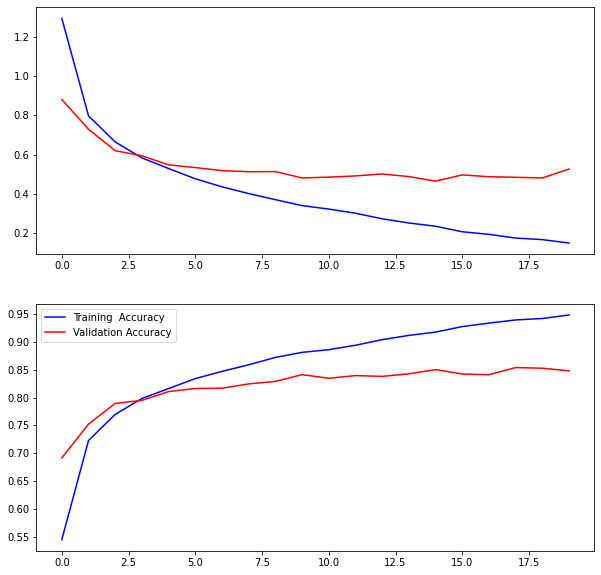

In [22]:
plot_history(vgg19)

In [23]:
scores = vgg19.evaluate(x_test, y_test, batch_size=100)
print('Test loss : ', scores[0])
print('Test accuracy : ', scores[1])

100/100 [==============================] - 2s 13ms/step - loss: 0.5097 - accuracy: 0.8518
Test loss :  0.5097471475601196
Test accuracy :  0.8518000245094299


## ResNet

### Define Residual Unit

In [24]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [25]:
# learning rate scheduler
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0,patience=5, min_lr=0.5e-6)
# earlt stopping
early_stopper = EarlyStopping(min_delta=0.001, patience=10)

### ResNet-18

In [26]:
# build ResNet-18
rn18 = keras.models.Sequential()
rn18.add(DefaultConv2D(64, kernel_size=7, strides=2,input_shape=(32,32,3)))
rn18.add(keras.layers.BatchNormalization())
rn18.add(keras.layers.Activation("relu"))
rn18.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 2 + [128] * 2 + [256] * 2 + [512] * 2:
    strides = 1 if filters == prev_filters else 2
    rn18.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
rn18.add(keras.layers.GlobalAvgPool2D())
rn18.add(keras.layers.Flatten())
rn18.add(keras.layers.Dense(10, activation="softmax"))

In [27]:
rn18.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# fit the model on the batches generated by the generator.
rn18.fit(train_generator.flow(x_train, y_train, batch_size=32),
         validation_data=val_generator.flow(x_validation,y_validation,batch_size=32),
         steps_per_epoch = x_train.shape[0] // 32,
         epochs=200,
         callbacks=[lr_reducer, early_stopper])

Epoch 1/200
1250/1250 [==============================] - 36s 27ms/step - loss: 1.5587 - accuracy: 0.4500 - val_loss: 1.8689 - val_accuracy: 0.4475
Epoch 2/200
1250/1250 [==============================] - 34s 27ms/step - loss: 1.2292 - accuracy: 0.5722 - val_loss: 1.3417 - val_accuracy: 0.5392
Epoch 3/200
1250/1250 [==============================] - 34s 27ms/step - loss: 1.0385 - accuracy: 0.6415 - val_loss: 1.4900 - val_accuracy: 0.5029
Epoch 4/200
1250/1250 [==============================] - 34s 27ms/step - loss: 0.9510 - accuracy: 0.6720 - val_loss: 1.1645 - val_accuracy: 0.5941
Epoch 5/200
1250/1250 [==============================] - 34s 27ms/step - loss: 0.8518 - accuracy: 0.7069 - val_loss: 0.9970 - val_accuracy: 0.6617
Epoch 6/200
1250/1250 [==============================] - 34s 27ms/step - loss: 0.7883 - accuracy: 0.7275 - val_loss: 0.8751 - val_accuracy: 0.7045
Epoch 7/200
1250/1250 [==============================] - 34s 27ms/step - loss: 0.7592 - accuracy: 0.7407 - val_loss: 0

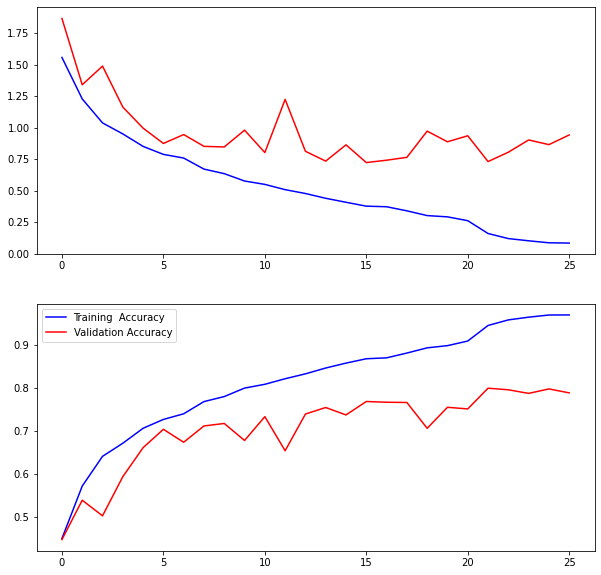

In [28]:
plot_history(rn18)

### ResNet-34

In [29]:
# build resnet-34
rn34 = keras.models.Sequential()
rn34.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
rn34.add(keras.layers.BatchNormalization())
rn34.add(keras.layers.Activation("relu"))
rn34.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    rn34.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
rn34.add(keras.layers.GlobalAvgPool2D())
rn34.add(keras.layers.Flatten())
rn34.add(keras.layers.Dense(10, activation="softmax"))

In [30]:
rn34.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [31]:
rn34.fit(train_generator.flow(x_train, y_train, batch_size=32),
         validation_data=val_generator.flow(x_validation,y_validation,batch_size=32),
         steps_per_epoch = x_train.shape[0] // 32,
         epochs=200,
         callbacks=[lr_reducer, early_stopper])

Epoch 1/200
1250/1250 [==============================] - 46s 35ms/step - loss: 1.7068 - accuracy: 0.4023 - val_loss: 3.7254 - val_accuracy: 0.1654
Epoch 2/200
1250/1250 [==============================] - 43s 34ms/step - loss: 1.3684 - accuracy: 0.5214 - val_loss: 1.8678 - val_accuracy: 0.4224
Epoch 3/200
1250/1250 [==============================] - 43s 34ms/step - loss: 1.1873 - accuracy: 0.5899 - val_loss: 1.6593 - val_accuracy: 0.4231
Epoch 4/200
1250/1250 [==============================] - 42s 34ms/step - loss: 1.0626 - accuracy: 0.6334 - val_loss: 1.2249 - val_accuracy: 0.5881
Epoch 5/200
1250/1250 [==============================] - 43s 34ms/step - loss: 0.9741 - accuracy: 0.6625 - val_loss: 1.0111 - val_accuracy: 0.6523
Epoch 6/200
1250/1250 [==============================] - 43s 34ms/step - loss: 0.9101 - accuracy: 0.6881 - val_loss: 1.9960 - val_accuracy: 0.3593
Epoch 7/200
1250/1250 [==============================] - 43s 34ms/step - loss: 0.8605 - accuracy: 0.7078 - val_loss: 1

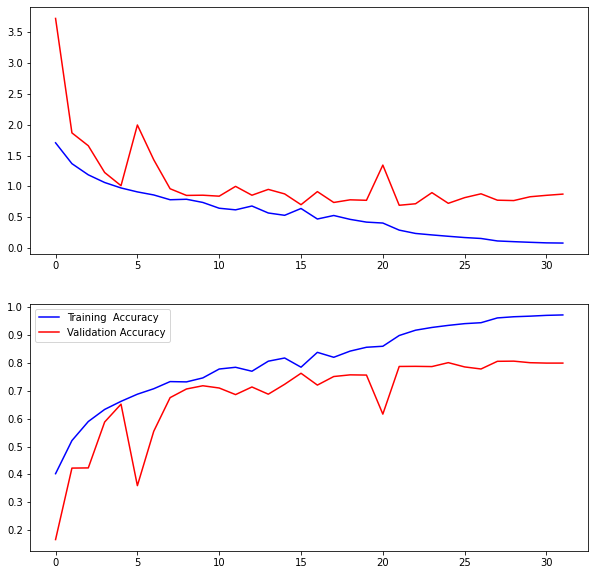

In [32]:
plot_history(rn34)

## Test Result
Since VGG-19 has the best validation result. I decided to use VGG-19 for the testing.

In [33]:
scores = vgg19.evaluate(x_test, y_test, batch_size=100)
print('Test loss : ', scores[0])
print('Test accuracy : ', scores[1])

100/100 [==============================] - 1s 14ms/step - loss: 0.5097 - accuracy: 0.8518
Test loss :  0.5097471475601196
Test accuracy :  0.8518000245094299
